# Project4: West Nile Virus Prediction

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import os
from sklearn.model_selection import GridSearchCV
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import geopy.distance
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from xgboost import XGBClassifier

import imblearn

import warnings
warnings.filterwarnings('ignore')


## Importing Data

In [4]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
weather_df = pd.read_csv('Data/weather_last_cleaned.csv')
spray_df = pd.read_csv('Data/spray.csv')

In [5]:
pd.set_option("display.max_columns", None)

In [6]:
#Check the data
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [7]:
#Check the data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [8]:
#Change the data type of date column
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

#Create a new column to indicate the year
train_df['Year'] = train_df['Date'].dt.year
test_df['Year'] = test_df['Date'].dt.year

#Create a new column to indicate the month
train_df['Month'] = train_df['Date'].dt.month
test_df['Month'] = test_df['Date'].dt.month

#Create a new column to indicate the week
train_df['Week'] = train_df['Date'].dt.isocalendar().week
test_df['Week'] = test_df['Date'].dt.isocalendar().week

#check the data type again
train_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  Year                    10506 non-null  int64 

In [9]:
#Check the missing value
train_df.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Year                      0
Month                     0
Week                      0
dtype: int64

In [10]:
#Check shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)
print(spray_df.shape)


(10506, 15)
(116293, 14)
(14835, 4)


## Exploratory Data Analysis

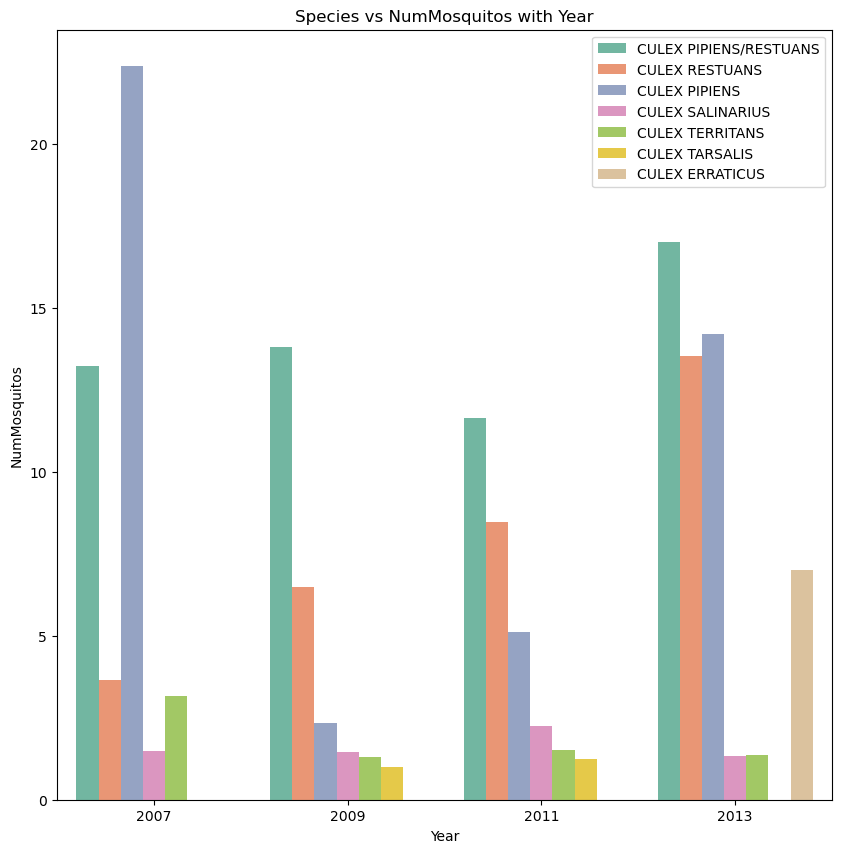

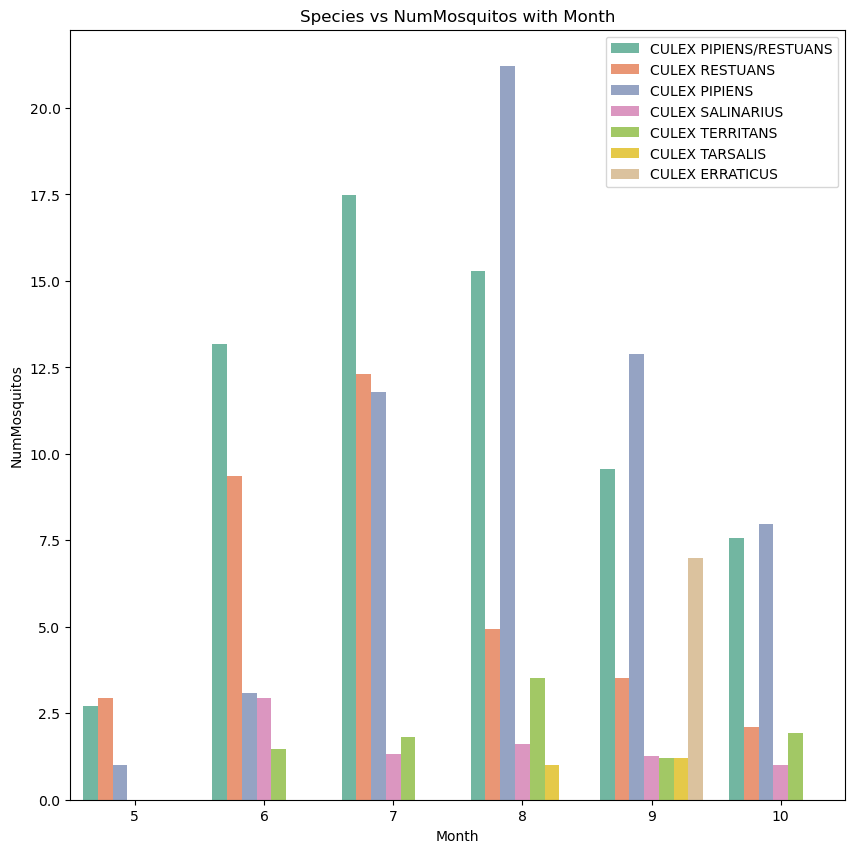

In [11]:
#check Species column with the number of mosquitos and year
plt.figure(figsize=(10, 10))
train_df.groupby(['Species', 'Year'])['NumMosquitos'].sum()

#visualize the number of mosquitos and year with Species
sns.barplot(x='Year', y='NumMosquitos', hue='Species', data=train_df,ci=None, palette='Set2')
plt.title('Species vs NumMosquitos with Year')
plt.legend(loc='upper right')
plt.show()

#visualize the number of mosquitos and month with Species 
plt.figure(figsize=(10, 10))
sns.barplot(x='Month', y='NumMosquitos', hue='Species', data=train_df,ci=None, palette='Set2')
plt.title('Species vs NumMosquitos with Month')
plt.legend(loc='upper right')





<Figure size 1000x600 with 0 Axes>

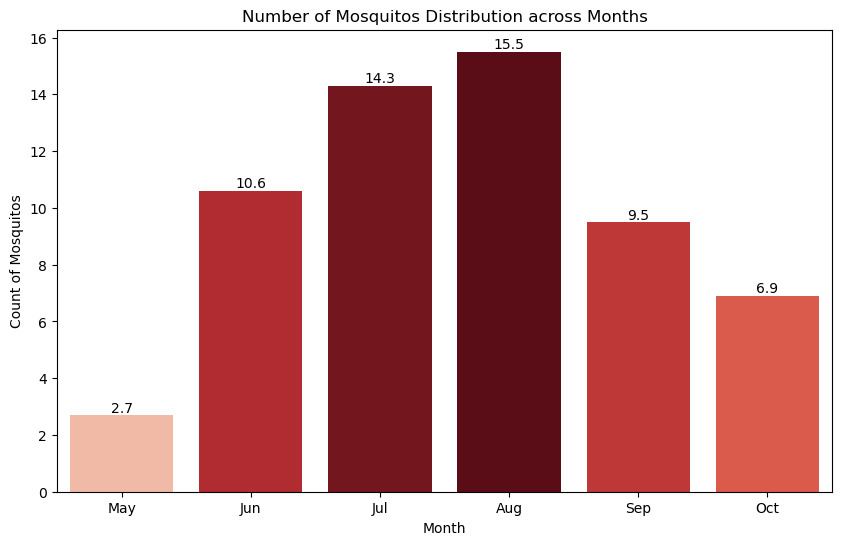

In [12]:
# Bar plot of distribution of mosquitos by month
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Calculate the mean number of mosquitos for each month
mean_mosquitos = train_df.groupby("Month")["NumMosquitos"].mean().round(1)

# Import the TwoSlopeNorm for color normalization
from matplotlib.colors import TwoSlopeNorm

# Define normalization for colors based on the mean number of mosquitos
norm = TwoSlopeNorm(vmin=0, vcenter=5, vmax=mean_mosquitos.max())

# Create a list of colors based on the mean number of mosquitos using Reds colormap
colors = [plt.cm.Reds(norm(c)) for c in mean_mosquitos]

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a bar plot using seaborn with the mean number of mosquitos and specified parameters
ax = sns.barplot(x=mean_mosquitos.index, y=mean_mosquitos, errorbar=None, palette=colors)

# Set the x-axis tick labels for months
ax.set(xticklabels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

# Set the title and y-axis label for the plot
plt.title('Number of Mosquitos Distribution across Months')
plt.ylabel('Count of Mosquitos')

# Adding labels to the bars displaying the value of each bar
for i, val in enumerate(mean_mosquitos):
    ax.text(i, val, f'{val}', ha='center', va='bottom');


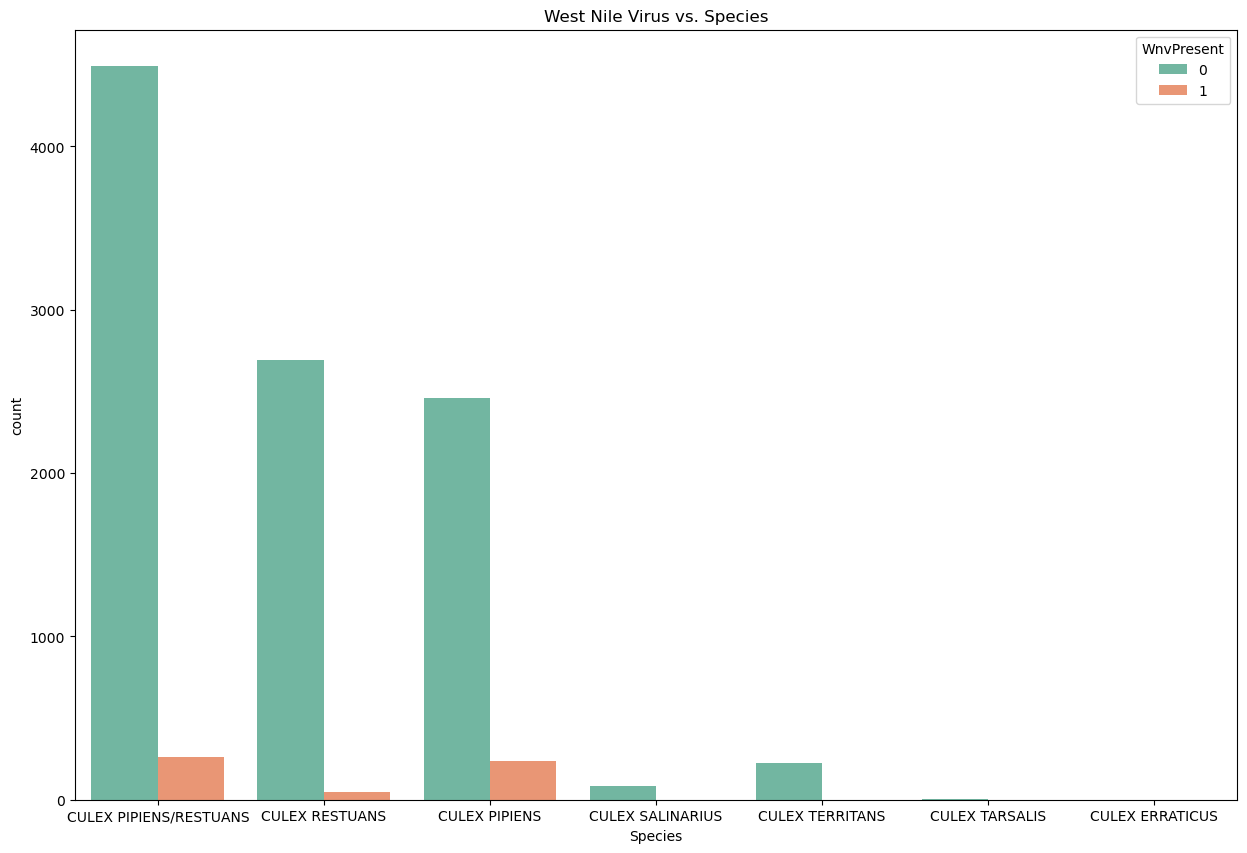

In [13]:
#Check species with WnvPresent = 1 in each year
plt.figure(figsize=(15, 10))
train_df[train_df['WnvPresent']==1].groupby(['Species', 'Year'])['WnvPresent'].sum()

#visualize the number of WnvPresent and year with Species
sns.countplot(x="Species", hue=train_df["WnvPresent"], data=train_df, palette='Set2')
plt.title('West Nile Virus vs. Species') 
plt.show()






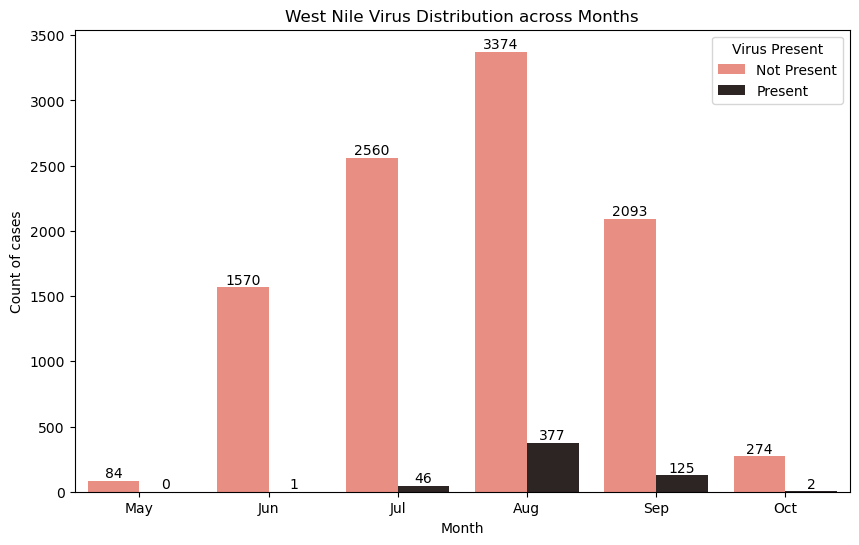

In [14]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create a countplot using seaborn to visualize the distribution of 'WnvPresent' across months
ax = sns.countplot(data=train_df, x='Month', hue='WnvPresent', palette='dark:salmon_r')

# Add labels to the bars representing the counts of 'WnvPresent' (Not Present and Present)
ax.bar_label(ax.containers[0])  # Label for 'Not Present'
ax.bar_label(ax.containers[1])  # Label for 'Present'

# Create a diverging color palette (this line doesn't affect the plot, as the palette is not assigned to any plot)
sns.diverging_palette(220, 20, as_cmap=True)

# Set title, labels, and legend for the plot
plt.title('West Nile Virus Distribution across Months')
plt.xlabel('Month')
ax.set(xticklabels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])  # Set x-axis tick labels
plt.ylabel('Count of cases')
plt.legend(title='Virus Present', loc='upper right', labels=['Not Present', 'Present'])  # Add legend with labels

# Save the plot as an image file
plt.savefig('virus distribution.png')


In [15]:
#Check shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 15)
(116293, 14)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  Year                    10506 non-null  int64 

In [17]:
#Check the number of unique values in each column
train_df.nunique()

Date                       95
Address                   138
Species                     7
Block                      64
Street                    128
Trap                      136
AddressNumberAndStreet    138
Latitude                  138
Longitude                 138
AddressAccuracy             4
NumMosquitos               50
WnvPresent                  2
Year                        4
Month                       6
Week                       20
dtype: int64

In [18]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Week
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22


In [19]:
#Find what latitude and longitude have most WnvPresent = 1
print(train_df[train_df['WnvPresent']==1].groupby(['Latitude', 'Longitude'])['WnvPresent'].sum().sort_values(ascending=False).head(10))

#create a new column to find a distance between the most WnvPresent = 1 and each row
train_df['Distance'] = np.sqrt((train_df['Latitude']-41.974689)**2 + (train_df['Longitude']-(-87.890615))**2)
test_df['Distance'] = np.sqrt((test_df['Latitude']-41.974689)**2 + (test_df['Longitude']-(-87.890615))**2)


Latitude   Longitude 
41.974689  -87.890615    66
41.673408  -87.599862    41
41.954690  -87.800991    18
41.726465  -87.585413    16
41.964242  -87.757639    14
41.944869  -87.832763    11
41.743402  -87.731435    11
41.704572  -87.565666    11
41.957799  -87.930995    10
42.008314  -87.777921    10
Name: WnvPresent, dtype: int64


In [20]:
#Join  train_df and weather_df on Date use only station 1
#also try station 2 but the result is not good
train_df = train_df.merge(weather_df[weather_df['Station']==1], on='Date')
test_df = test_df.merge(weather_df[weather_df['Station']==1], on='Date')




In [21]:
#Check train_df and test_df 
train_df.head()


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Week,Distance,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Rain,Mist,Haze,RH
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,0.091828,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,0.091828,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22,0.123023,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22,0.065806,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22,0.065806,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0


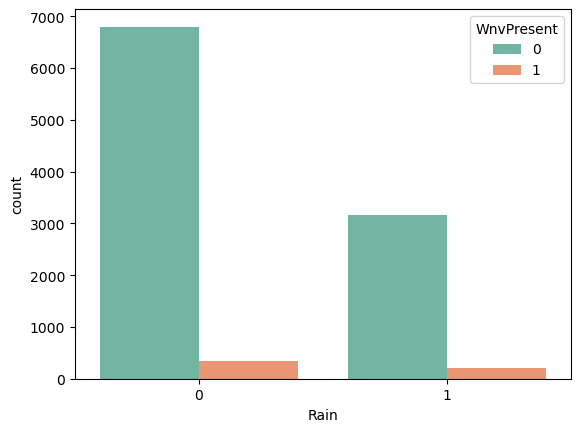

In [22]:
#check the number of WnvPresent = 1 with Rain
train_df[train_df['WnvPresent']==1].groupby('Rain')['WnvPresent'].sum() 

#visualize the number of WnvPresent = 1 with Rain
sns.countplot(x="Rain", hue=train_df["WnvPresent"], data=train_df, palette='Set2')
plt.show()





<Figure size 1000x600 with 0 Axes>

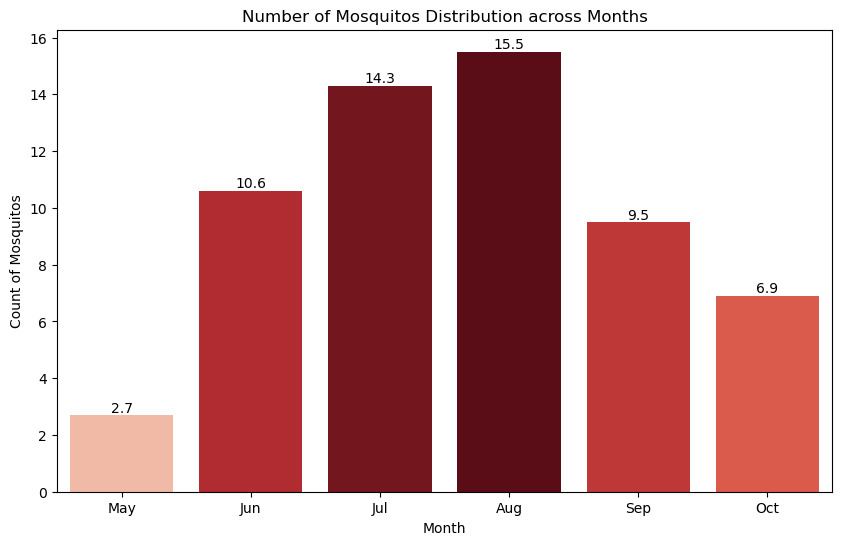

In [23]:
# This code creates a bar plot of the distribution of mosquitos by month.

# Set the size of the figure for the first plot (not used in the code)
plt.figure(figsize=(10, 6))

# Calculate the mean number of mosquitos for each month
mean_mosquitos = train_df.groupby("Month")["NumMosquitos"].mean().round(1)

# Import TwoSlopeNorm from matplotlib.colors for color normalization
from matplotlib.colors import TwoSlopeNorm

# Create normalization based on the mean number of mosquitos
norm = TwoSlopeNorm(vmin=0, vcenter=5, vmax=mean_mosquitos.max())

# Generate colors based on the normalization using the Reds colormap
colors = [plt.cm.Reds(norm(c)) for c in mean_mosquitos]

# Create a new figure for the second plot
plt.figure(figsize=(10, 6))

# Create a bar plot using seaborn with the mean number of mosquitos and specified parameters
ax = sns.barplot(x=mean_mosquitos.index, y=mean_mosquitos, errorbar=None, palette=colors)

# Set x-axis tick labels for months
ax.set(xticklabels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

# Set title and y-axis label for the plot
plt.title('Number of Mosquitos Distribution across Months')
plt.ylabel('Count of Mosquitos')

# Adding labels to the bars showing the values of mean mosquitos
for i, val in enumerate(mean_mosquitos):
    ax.text(i, val, f'{val}', ha='center', va='bottom')


In [24]:
# Function to calculate distianct betwen Trap station
station1 = (41.995, -87.933) #Trap Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Trap Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km # calculate distance to station 1
    dist2 = geopy.distance.distance((lat, long), station2).km # calculate distance to station 2
    return 1 if dist1 < dist2 else 2

In [25]:
#spray_area = spray.groupby(['Latitude','Longitude'], as_index=False).sum().reindex()
spray_area = spray_df[['Latitude','Longitude']]
spray_area.head()
spray_area_list = spray_area.values.tolist()

location_df = train_df[['Address','Block','Street','AddressNumberAndStreet','Latitude','Longitude']]
location_df['Station_Loc'] = [get_station(location_df.loc[i,'Latitude'],location_df.loc[i,'Longitude']) for i in location_df.index]

# Create new dataset with groupby Date, Latitude, Longitude and filter WnvPresent > 0
wnv_present = train_df.groupby(['Date','Latitude','Longitude'], as_index=False).sum().reindex()
wnv_present = wnv_present.loc[wnv_present['WnvPresent'] > 0 ,['Date','Latitude','Longitude','NumMosquitos','WnvPresent']]

# Create Dataset collect location has Mosquito
mos_present = train_df.groupby(['Date','Latitude','Longitude'], as_index=False).sum().reindex()
mos_present = mos_present.loc[mos_present['NumMosquitos'] > 30 ,['Date','Latitude','Longitude','NumMosquitos','WnvPresent']]

# Convert location infected to list
wnv_present_list = wnv_present.values.tolist()
location_df_list = location_df.values.tolist()
mos_present_list = mos_present.values.tolist()

In [26]:
# Create dataset to plot mosquito and wnv in 2011 and 2013
total_wnv_2011 = wnv_present[wnv_present['Date'].dt.year==2011].groupby('Date')['WnvPresent'].sum()
total_wnv_2013 = wnv_present[wnv_present['Date'].dt.year==2013].groupby('Date')['WnvPresent'].sum()

total_mosquito_2011 = mos_present[mos_present['Date'].dt.year==2011].groupby('Date')['NumMosquitos'].sum()
total_mosquito_2013 = mos_present[mos_present['Date'].dt.year==2013].groupby('Date')['NumMosquitos'].sum()

In [27]:
# Create total spray in each year
spray_dates = spray_df['Date'].unique()
spray_2011 = spray_dates[:2]
spray_2013 = spray_dates[2:]

In [28]:
# Create spray area df
spray_area = spray_df[['Latitude','Longitude']]
spray_area.head()
# Convert spray area to lisz< ,mnåq1t
spray_area_list = spray_area.values.tolist()

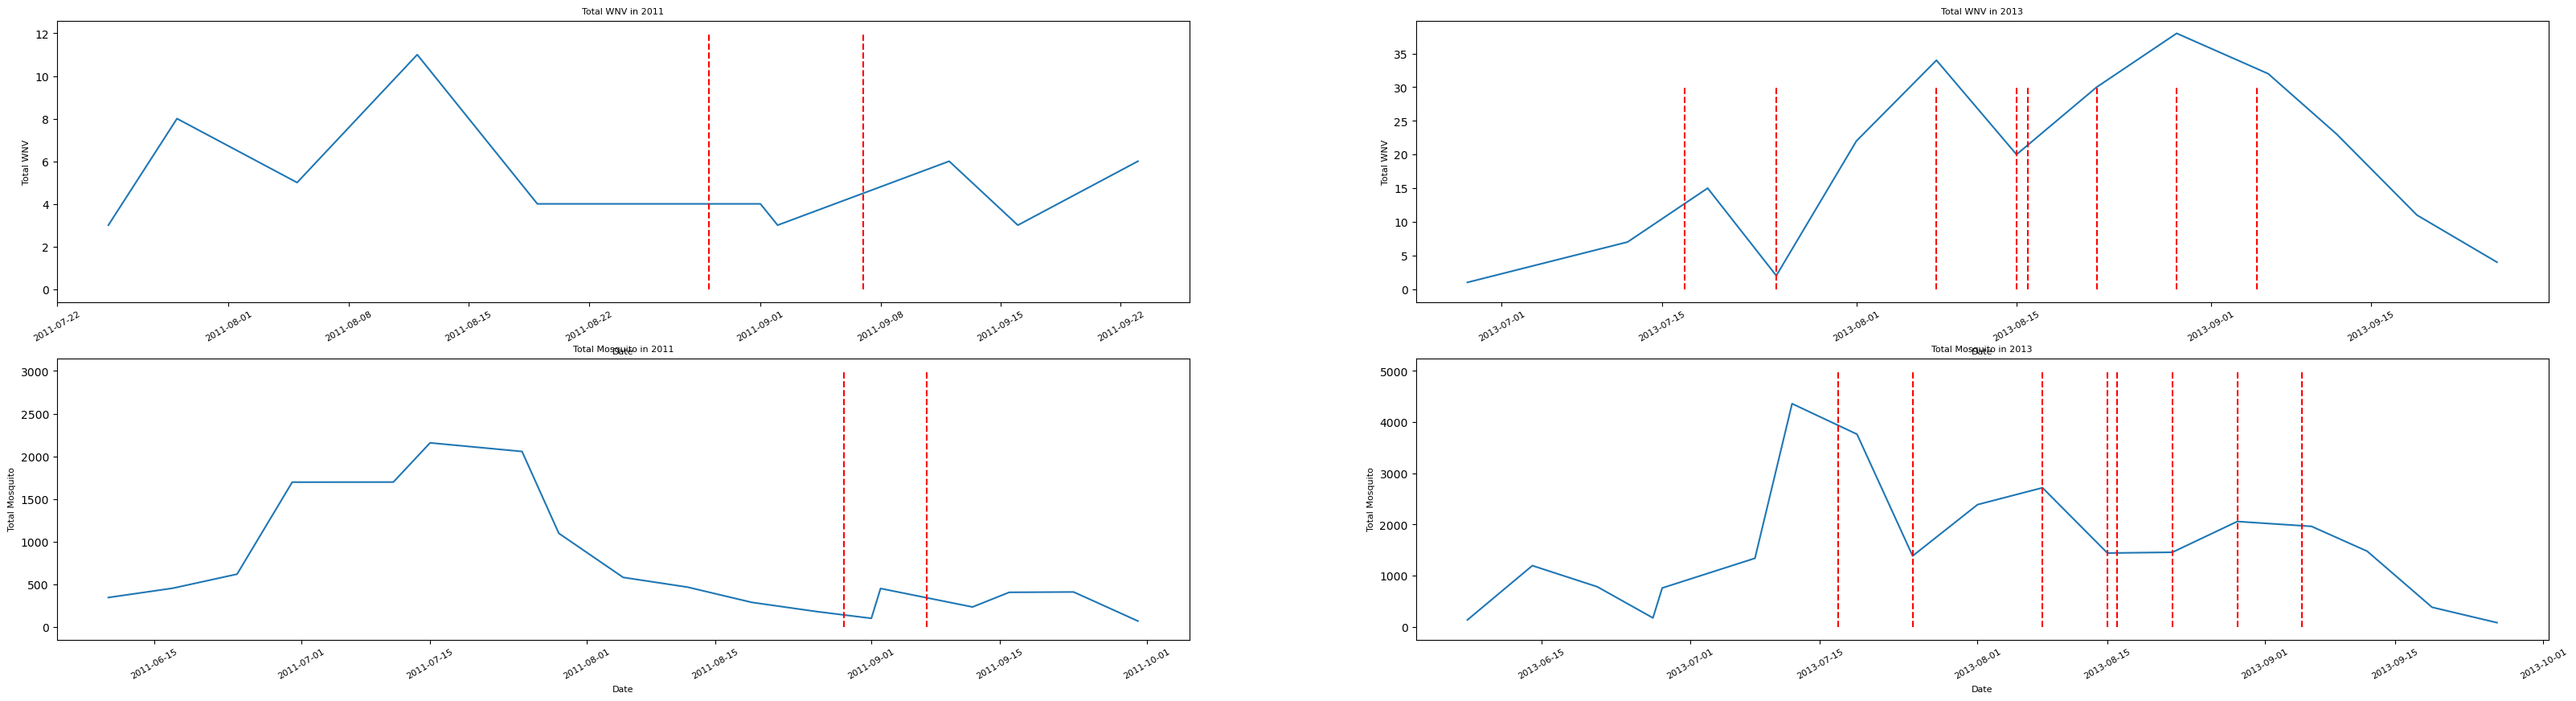

In [29]:
# Create a figure with 2x2 subplots and a specified size
fig, ax = plt.subplots(2, 2, figsize=(40, 10))

# Plotting Total WNV in 2011 on the first subplot (top-left)
ax[0][0].plot(total_wnv_2011)
ax[0][0].set_title('Total WNV in 2011', fontsize=8)  # Set title
ax[0][0].set_xlabel('Date', fontsize=8)  # Set x-axis label
ax[0][0].set_ylabel('Total WNV', fontsize=8)  # Set y-axis label
ax[0][0].vlines(spray_2011, 0, 12, color='red', linestyles='dashed')  # Vertical lines for spray_2011
ax[0][0].tick_params(axis='x', rotation=30, labelsize=8)  # Set x-axis tick parameters

# Plotting Total WNV in 2013 on the second subplot (top-right)
ax[0][1].plot(total_wnv_2013)
ax[0][1].set_title('Total WNV in 2013', fontsize=8)  # Set title
ax[0][1].set_xlabel('Date', fontsize=8)  # Set x-axis label
ax[0][1].set_ylabel('Total WNV', fontsize=8)  # Set y-axis label
ax[0][1].vlines(spray_2013, 0, 30, color='red', linestyles='dashed')  # Vertical lines for spray_2013
ax[0][1].tick_params(axis='x', rotation=30, labelsize=8)  # Set x-axis tick parameters

# Plotting Total Mosquito in 2011 on the third subplot (bottom-left)
ax[1][0].plot(total_mosquito_2011)
ax[1][0].set_title('Total Mosquito in 2011', fontsize=8)  # Set title
ax[1][0].set_xlabel('Date', fontsize=8)  # Set x-axis label
ax[1][0].set_ylabel('Total Mosquito', fontsize=8)  # Set y-axis label
ax[1][0].vlines(spray_2011, 0, 3000, color='red', linestyles='dashed')  # Vertical lines for spray_2011
ax[1][0].tick_params(axis='x', rotation=30, labelsize=8)  # Set x-axis tick parameters

# Plotting Total Mosquito in 2013 on the fourth subplot (bottom-right)
ax[1][1].plot(total_mosquito_2013)
ax[1][1].set_title('Total Mosquito in 2013', fontsize=8)  # Set title
ax[1][1].set_xlabel('Date', fontsize=8)  # Set x-axis label
ax[1][1].set_ylabel('Total Mosquito', fontsize=8)  # Set y-axis label
ax[1][1].vlines(spray_2013, 0, 5000, color='red', linestyles='dashed')  # Vertical lines for spray_2013
ax[1][1].tick_params(axis='x', rotation=30, labelsize=8)  # Set x-axis tick parameters



In [30]:
#check the shape of train_df, test_df, and spray_df
print(train_df.shape)
print(test_df.shape)
print(spray_df.shape)

(10506, 37)
(116293, 36)
(14835, 4)


In [31]:
#Check Trap column
train_df['Trap'].value_counts()

#if contain 5 Character remove the last character because it should be 4 character
train_df['Trap'] = train_df['Trap'].apply(lambda x: x[:-1] if len(x)==5 else x)
test_df['Trap'] = test_df['Trap'].apply(lambda x: x[:-1] if len(x)==5 else x)





In [32]:
#Check data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  Year                    10506 non-null  int64 

In [33]:
#check the shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 37)
(116293, 36)


In [34]:
#Check Address columns
train_df['Address'].value_counts()

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA         750
South Doty Avenue, Chicago, IL, USA                                          542
South Stony Island Avenue, Chicago, IL, USA                                  314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                           185
4200 West 127th Street, Alsip, IL 60803, USA                                 183
                                                                            ... 
3400 West 77th Street, Chicago, IL 60652, USA                                  7
5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA      5
9600 South Longwood Drive, Chicago, IL 60643, USA                              5
2900 West 85th Street, Chicago, IL 60652, USA                                  3
2100 South Hamlin Avenue, Chicago, IL 60623, USA                               2
Name: Address, Length: 138, dtype: int64

In [35]:
#Seperate Address into two columns (Street and City)
train_df['Street'] = train_df['Address'].apply(lambda x: x.split(',')[0])
train_df['City'] = train_df['Address'].apply(lambda x: x.split(',')[1].strip())
test_df['Street'] = test_df['Address'].apply(lambda x: x.split(',')[0])
test_df['City'] = test_df['Address'].apply(lambda x: x.split(',')[1].strip())

In [36]:
#seperate Catagorical and Numerical columns 
cat_cols_train = train_df[['Species', 'Street', 'City', 'Trap']]
num_cols_train = train_df[['Latitude', 'Longitude', 'Year', 'Month', 'Distance', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]
cat_cols_test = test_df[['Species', 'Street', 'City', 'Trap']]
num_cols_test = test_df[['Latitude', 'Longitude', 'Year', 'Month', 'Distance','Tavg', 'DewPoint', 'WetBulb',  'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]


<Axes: >

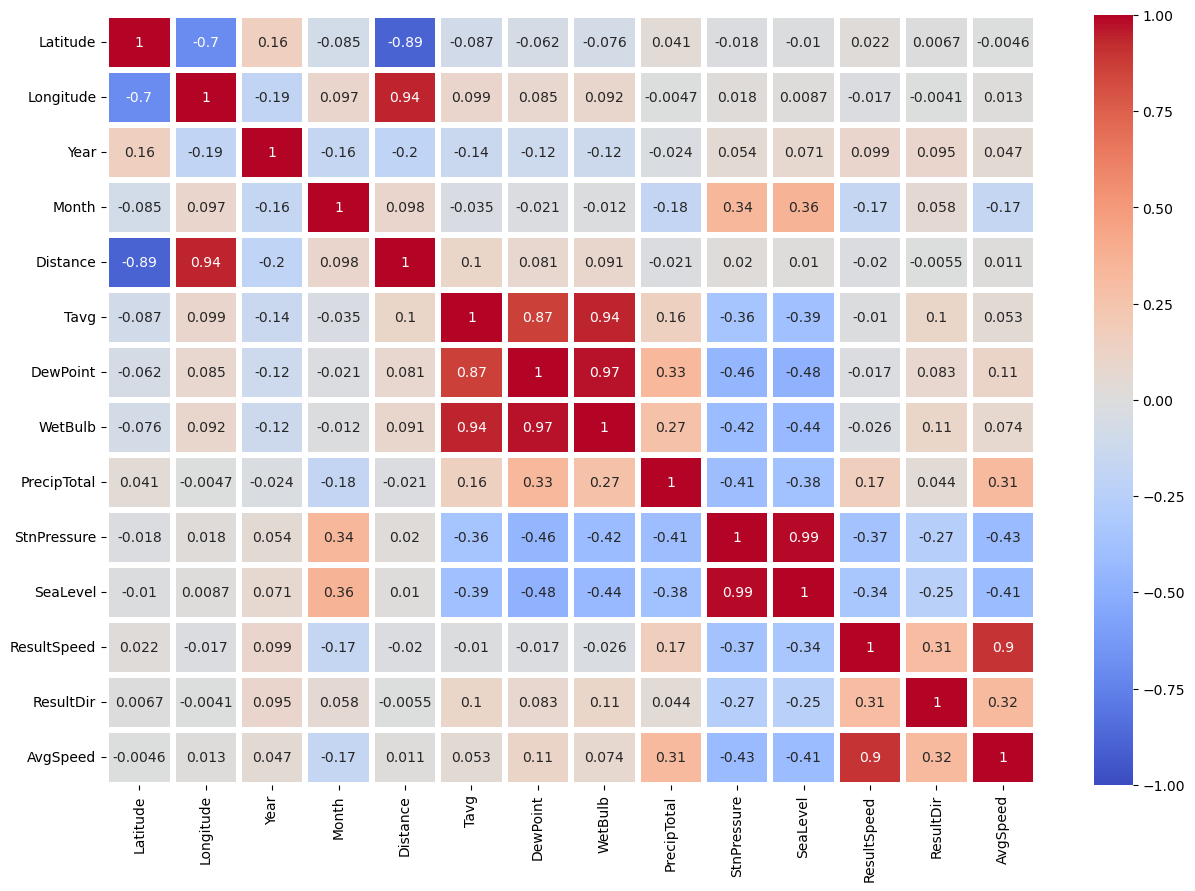

In [37]:
#Check correlation of numeric data 
plt.figure(figsize=(15,10))
sns.heatmap(num_cols_train.corr(),annot=True, cmap='coolwarm', vmin=-1, vmax=1, center= 0, linewidths=3, linecolor='white')

Text(0.5, 1.0, 'Numerical Features Correlation')

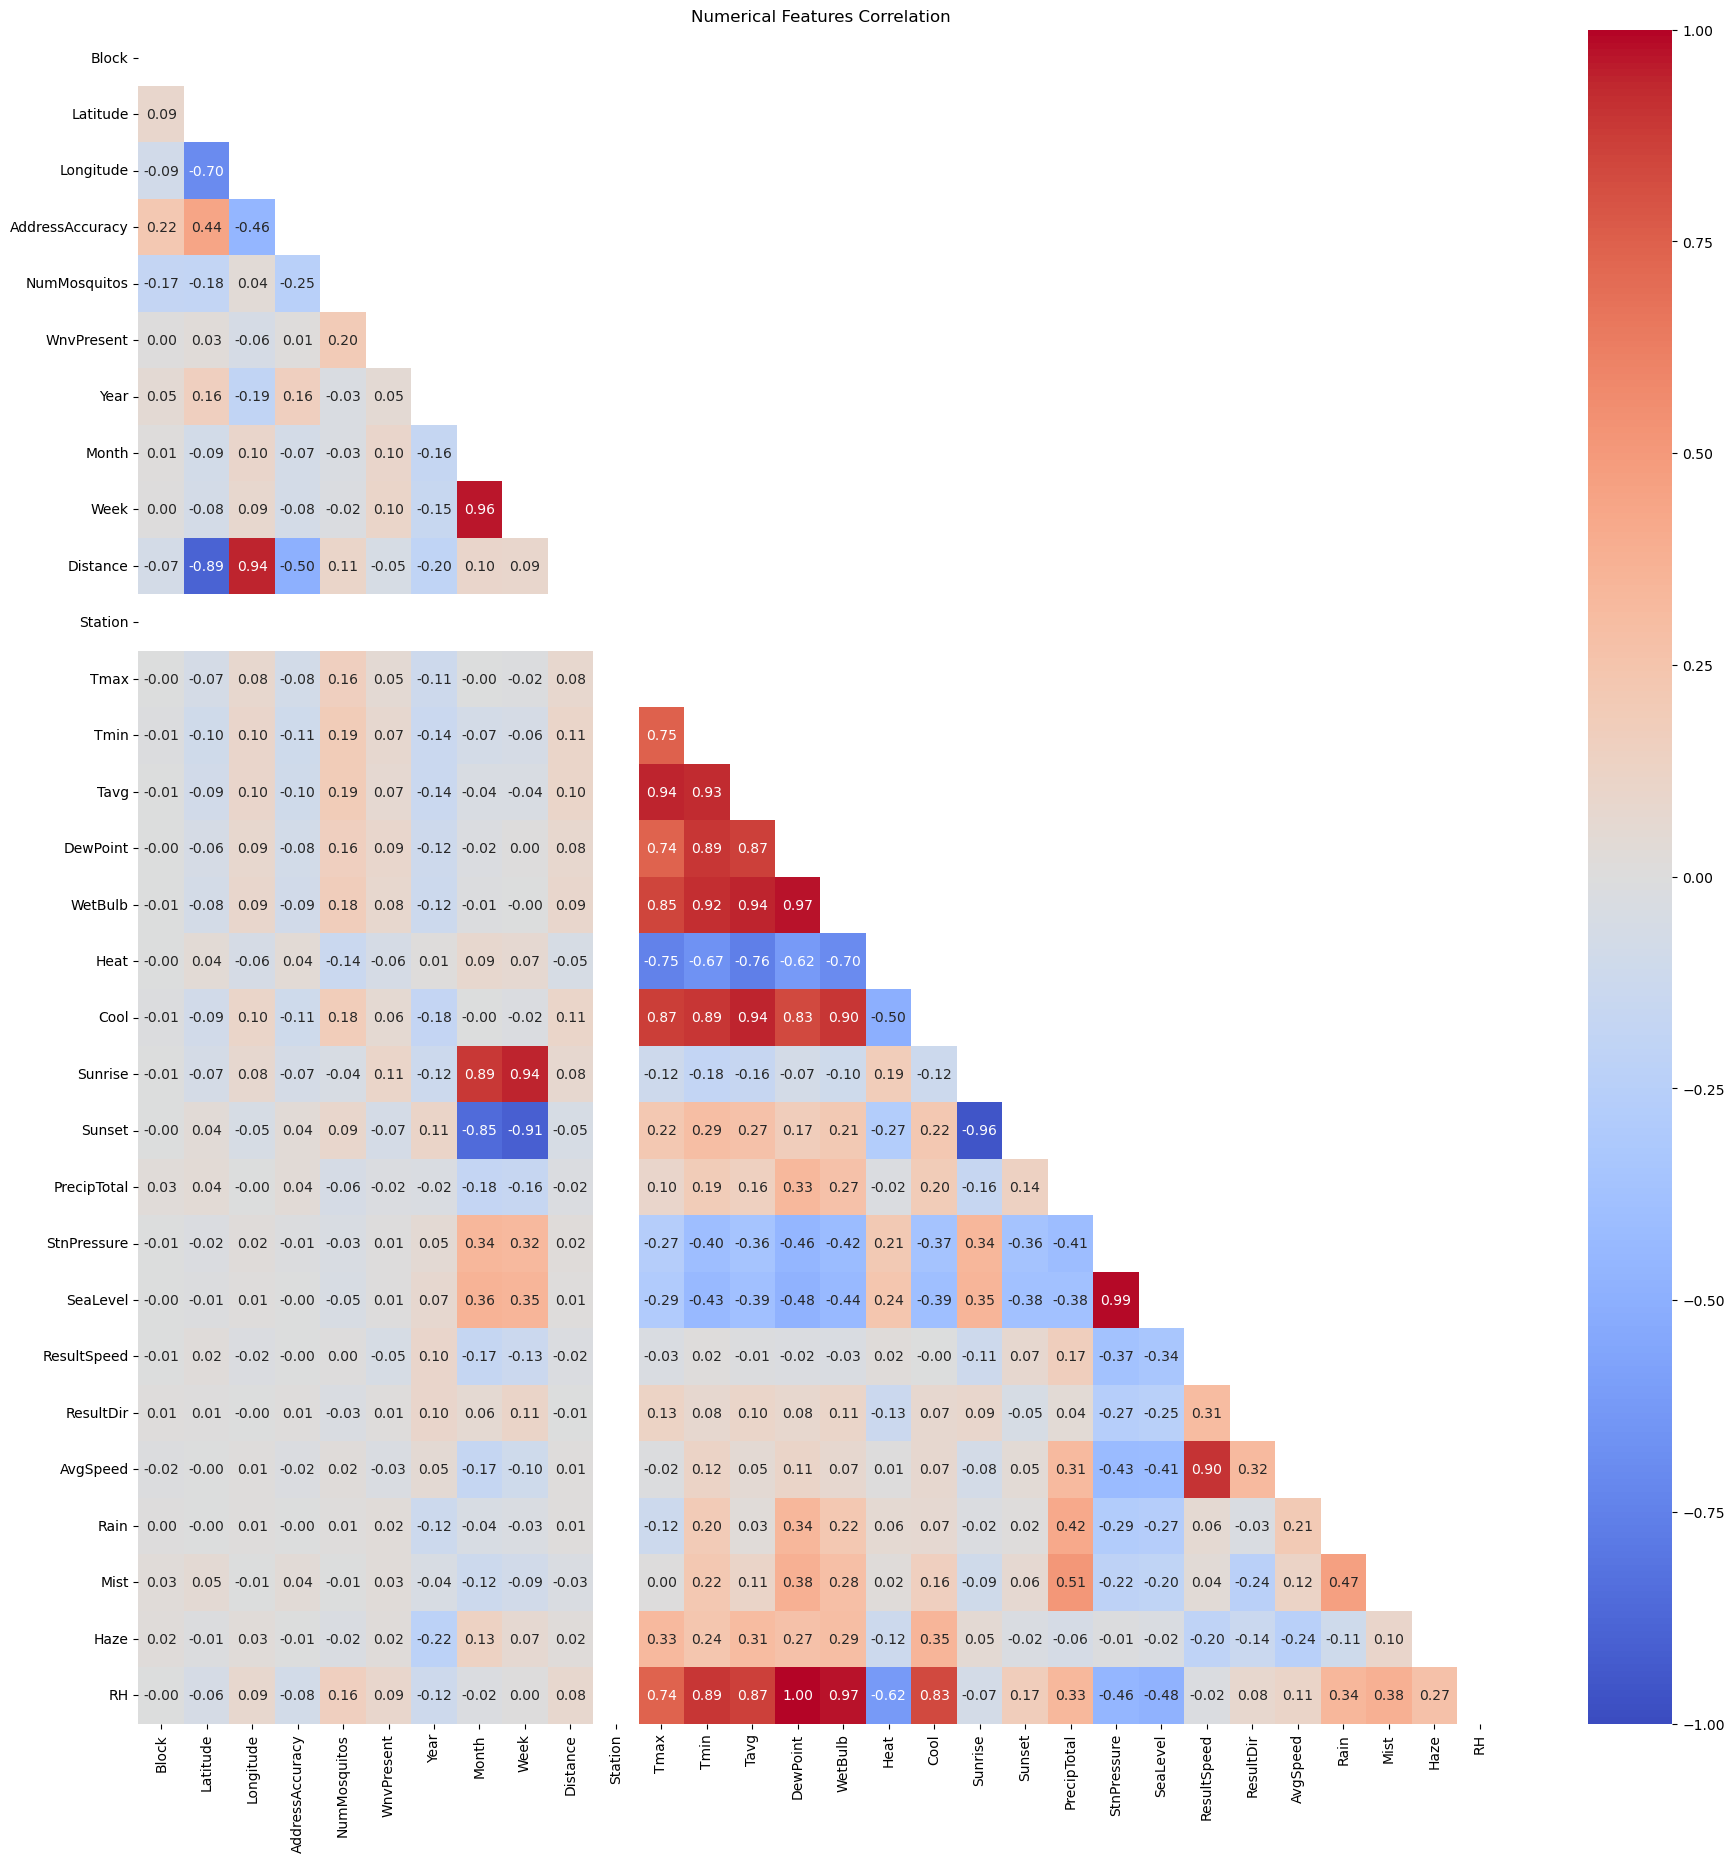

In [38]:
# Set correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure
plt.figure(figsize=(22, 22))

# Create a correlation heatmap with the mask
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Set the title
plt.title('Numerical Features Correlation')

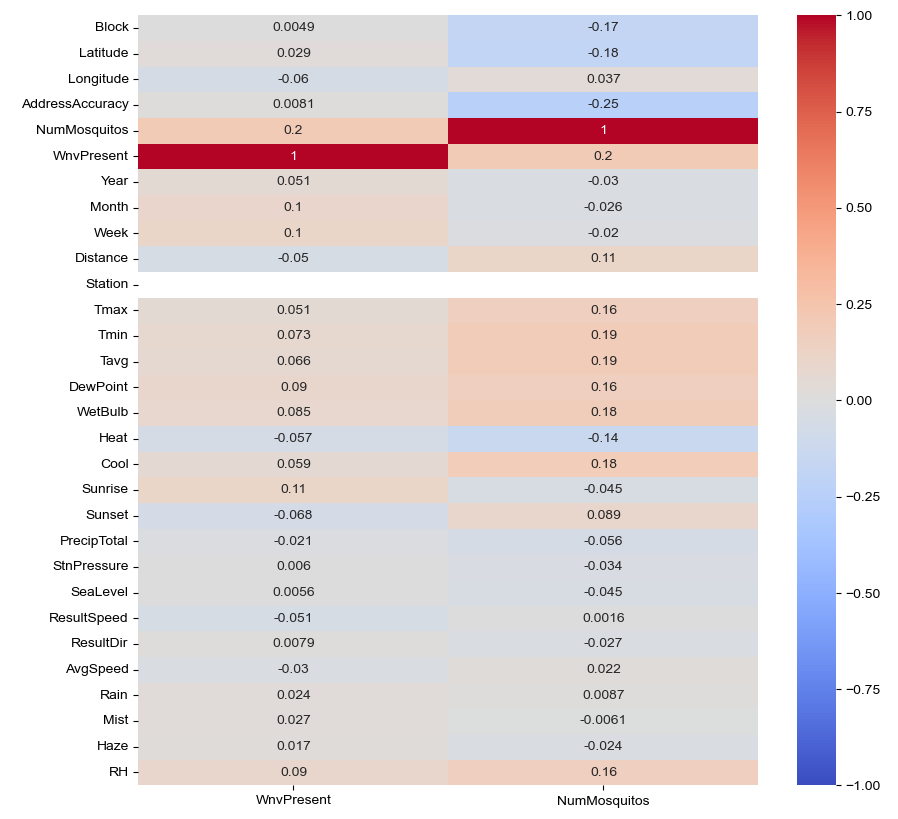

In [39]:
# Create a heatmap using Seaborn to visualize correlations between 'WnvPresent' and 'NumMosquitos' columns in the 'train_df' DataFrame
plt.figure(figsize=(10, 10))  # Set the size of the heatmap figure

# Use train_df.corr() to calculate the correlation matrix for numeric columns only and extract correlations with 'WnvPresent' and 'NumMosquitos'
# Create a heatmap with annotations showing correlation values
sns.heatmap(train_df.corr(numeric_only=True)[['WnvPresent', 'NumMosquitos']], annot=True, vmin=-1, vmax=1, cmap="coolwarm")

sns.set(font_scale=1.3)  # Set the font scale for better readability of annotations



In [40]:
#Drop columns NumMosquitos because it is not in test_df
train_df.drop(columns='NumMosquitos', inplace=True)

## Pre-processing

In [41]:
#Chage categorical columns to dummy variables
cat_cols_train = pd.get_dummies(cat_cols_train, drop_first=True)
cat_cols_test = pd.get_dummies(cat_cols_test, drop_first=True)

#Concat cat_cols and num_cols
train_model = pd.concat([cat_cols_train, num_cols_train], axis=1)
test_model = pd.concat([cat_cols_test, num_cols_test], axis=1)


#Check the shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 37)
(116293, 37)


In [42]:
#Set X and y
X = train_model
y = train_df['WnvPresent']

In [43]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)



In [44]:
#Check the shape of X_train and X_test
print(X_train.shape)
print(X_test.shape)

(7879, 298)
(2627, 298)


In [45]:
#check the shape of y_train and y_test
print(y_train.shape)
print(y_test.shape)


(7879,)
(2627,)


In [46]:
#Check the value counts of y_train
y_train.value_counts(normalize=True)


0    0.947582
1    0.052418
Name: WnvPresent, dtype: float64

In [47]:
#Use StandardScaler to scale the data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)


#Use SMOTE to balance the data
sm = SMOTE(random_state=42)
X_train_sc_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)
X_test_sc_sm, y_test_sm = sm.fit_resample(X_test_sc, y_test)

## Modeling

In [49]:
def evaluate(model):
    pred_valid = model.predict(X_test_sc)
    probs_train = model.predict_proba(X_train_sc)[:,1]
    probs_valid = model.predict_proba(X_test_sc)[:,1]
    auc_train = round(roc_auc_score(y_train, probs_train), 4)
    auc_valid = round(roc_auc_score(y_test, probs_valid), 4)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    fpr_valid, tpr_valid, _ = roc_curve(y_test, probs_valid)
    ## plot
    plt.figure(figsize=(12, 5))
    ## confusion matrix
    # Want to change the labels for the classes to 0 and 1 0 = no WNV, 1 = WNV
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test_sc)), display_labels=['No WNV', 'WNV']).plot(ax=ax)
    plt.grid(False); plt.title('Confusion Matrix for test')
    ## ROC curve
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=auc_train).plot(ax=ax, name='train')
    RocCurveDisplay(fpr=fpr_valid, tpr=tpr_valid, roc_auc=auc_valid).plot(ax=ax, name='test')
    plt.plot((0,1), (0,1)); plt.title(f'ROC curve (AUC: {auc_valid})')
    plt.show()

### Logistic Regression

0.9473284989122552
ROC_AUC_SCORE 0.7438875981856401
Recall score for 0: 0.9991964644435516
Recall score for 1: 0.0


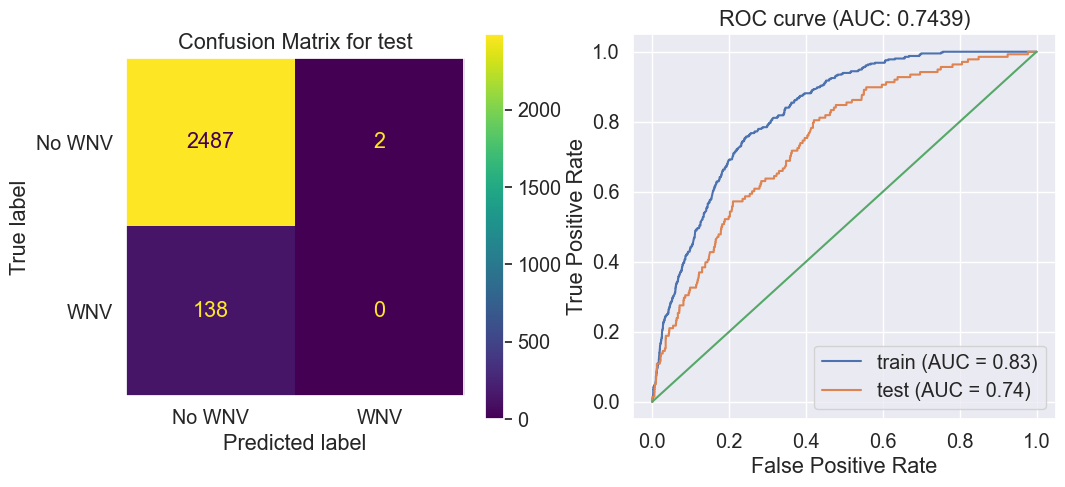

In [51]:
#use LogisticRegression with GridSearchCV to find the best parameters
lr = LogisticRegression()
lr_params = {
    'penalty': ['l2'],
    'C': [0.1]
}
gs = GridSearchCV(lr, param_grid=lr_params, cv=5)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_
#Check ROC_AUC score
print(f'ROC_AUC_SCORE {roc_auc_score(y_test, gs.predict_proba(X_test_sc)[:,1])}')
#Check recall score both 0 and 1
print(f'Recall score for 0: {recall_score(y_test, gs.predict(X_test_sc), pos_label=0)}')
print(f'Recall score for 1: {recall_score(y_test, gs.predict(X_test_sc), pos_label=1)}')
evaluate(gs)

**Model Evaluation**
- ROC AUC Score (0.7439) indicates that the model is performed moderately well
- Train AUC (0.83) and Test AUC (0.74), the model is overfit
-  Recall scrore for 0 (0.9992) indicates that the model is able to identify class 0 (no virus) effectively
-  Recall scrore for 1 (0) indicates the the model is cannot identify the presence of virus

### Random Forest Classifier

In [53]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [200],
    'max_depth': [None],
    'max_features': [2]
}
gs1 = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs1.fit(X_train_sc, y_train)
print(gs1.best_score_)
print(gs1.best_params_ )
#check ROC_AUC score
print(f'ROC_AUC_SCORE {roc_auc_score(y_test, gs1.predict_proba(X_test_sc)[:,1])}')
#Check recall score both 0 and 1
print(f'Recall score for 0: {recall_score(y_test, gs1.predict(X_test_sc), pos_label=0)}')
print(f'Recall score for 1: {recall_score(y_test, gs1.predict(X_test_sc), pos_label=1)}')

0.9454249456127629
{'max_depth': None, 'max_features': 2, 'n_estimators': 200}
ROC_AUC_SCORE 0.7478485044340025
Recall score for 0: 0.9907593411008437
Recall score for 1: 0.07971014492753623


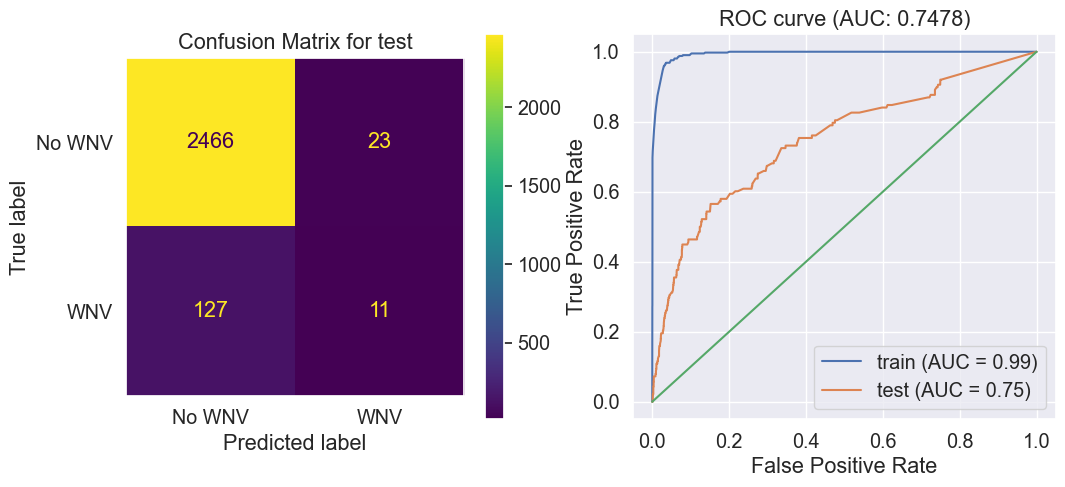

In [54]:
evaluate(gs1)

**Model Evaluation**
- ROC AUC Score (0.7507) indicates that the model is performed moderately well
- Train AUC (0.99) and Test AUC (0.75), the model is more overfit than previous Logistic Regression model
-  Recall scrore for 0 (0.9904) indicates that the model is able to identify class 0 (no virus) very effectively
-  Recall scrore for 1 (0.0797) indicates the model identify the presence of virus very poorly

### Random Forest Classifier: SMOTE

In [56]:
#use RandomforestClassifier with GridSearchCV to find the best parameters
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [200],
    'max_depth': [None],
    'max_features': [2]
    
}
gs2 = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs2.fit(X_train_sc_sm, y_train_sm)
print(gs2.best_score_)
print(gs2.best_params_ ) 

#check ROC_AUC score
print(f'ROC_AUC_SCORE {roc_auc_score(y_test, gs2.predict_proba(X_test_sc)[:,1])}')



print(f'Recall score for 0: {recall_score(y_test, gs2.predict(X_test_sc), pos_label=0)}')
print(f'Recall score for 1: {recall_score(y_test, gs2.predict(X_test_sc), pos_label=1)}')


0.9669864344062045
{'max_depth': None, 'max_features': 2, 'n_estimators': 200}
ROC_AUC_SCORE 0.7361855934226539
Recall score for 0: 0.9722780233025311
Recall score for 1: 0.18840579710144928


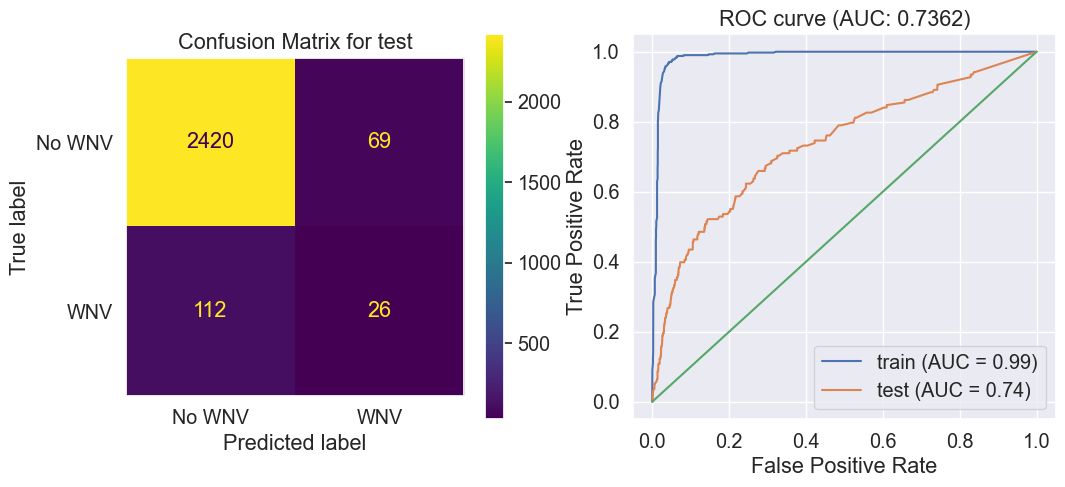

In [57]:
evaluate(gs2)

**Model Evaluation**
- ROC AUC Score (0.7376) indicates that the model is performed moderately well
- Train AUC (0.99) and Test AUC (0.74), the model is overfit
-  Recall scrore for 0 (0.9743) indicates that the model is able to identify class 0 (no virus) effectively
-  Recall scrore for 1 (0.1884) indicates the the model is ineffective in identifying the present of virus

### XGBoost Classifier

In [59]:
# Initialize an XGBoost classifier
xgb = XGBClassifier()

# Define the parameters to be tuned using GridSearchCV
xgb_params = {
    'n_estimators': [200],  # Number of trees in the ensemble
    'max_depth': [None],  # Maximum depth of each tree
    'learning_rate': [0.2]  # Learning rate of the boosting process
}

# Perform grid search with cross-validation (cv=5) to find the best parameters
gs3 = GridSearchCV(xgb, param_grid=xgb_params, cv=5)
gs3.fit(X_train_sc_sm, y_train_sm)  # Fit the grid search on the training data

# Print the best cross-validation score and the best parameters found
print(gs3.best_score_)
print(gs3.best_params_)

# Evaluate the model on the test set using ROC AUC score
print(roc_auc_score(y_test, gs3.predict_proba(X_test_sc)[:, 1]))

# Evaluate recall scores for both classes (0 and 1)
print(f'Recall score for 0: {recall_score(y_test, gs3.predict(X_test_sc), pos_label=0)}')
print(f'Recall score for 1: {recall_score(y_test, gs3.predict(X_test_sc), pos_label=1)}')

0.9601566376826934
{'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 200}
0.817210217711554
Recall score for 0: 0.9738850944154279
Recall score for 1: 0.16666666666666666


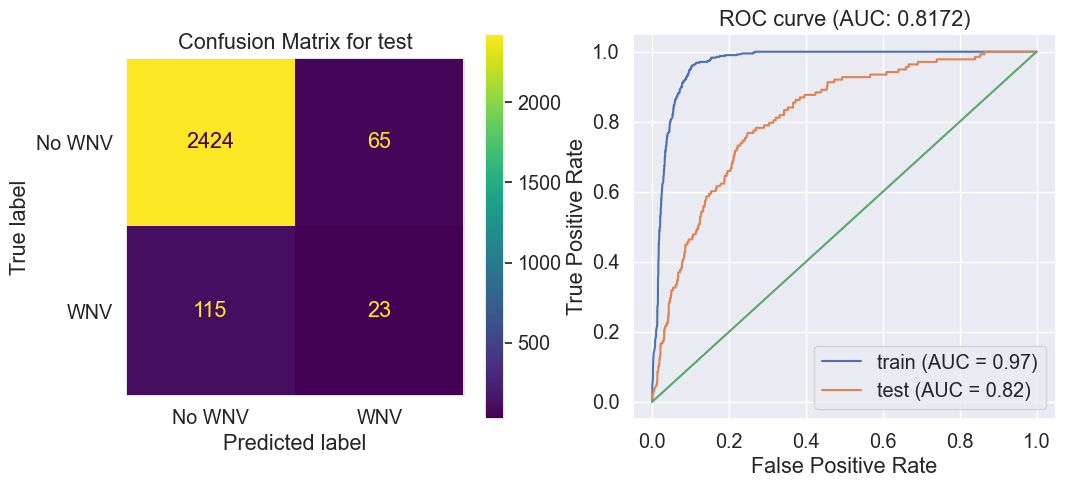

In [60]:
evaluate(gs3)
#From the result above, we can see that the model is overfitting but better than RandomforestClassifier 
#and ROC_AUC score tell mean Area under the curve is 0.82 which is good score 
#so we will use this model to predict the test data



**Model Evaluation**
- ROC AUC Score (0.8172) indicates that the model has improved from the previous Random Forest Classifier model. It performs well
- Train AUC (0.97) and Test AUC (0.82), the model is less overfit than the previous model
-  Recall scrore for 0 (0.9739) indicates that the model is able to identify class 0 (no virus) effectively
-  Recall scrore for 1 (0.1667) indicates the the model is ineffective in identifying the present of virus

**Final Model**
- Chosen model is XGBoostClassifier that will be implemented on the testing data

In [61]:
#Check the shape of X_train_sc and X_test_sc
print(X_train_sc.shape)
print(X_test_sc.shape)

(7879, 298)
(2627, 298)


                                importance
Month                             0.207479
Street_South Doty Avenue          0.063292
Species_CULEX RESTUANS            0.059800
Year                              0.055229
Tavg                              0.030952
Species_CULEX PIPIENS             0.028984
Street_ORD Terminal 5             0.022881
Species_CULEX PIPIENS/RESTUANS    0.020515
PrecipTotal                       0.020400
Street_4200 West 127th Street     0.016833


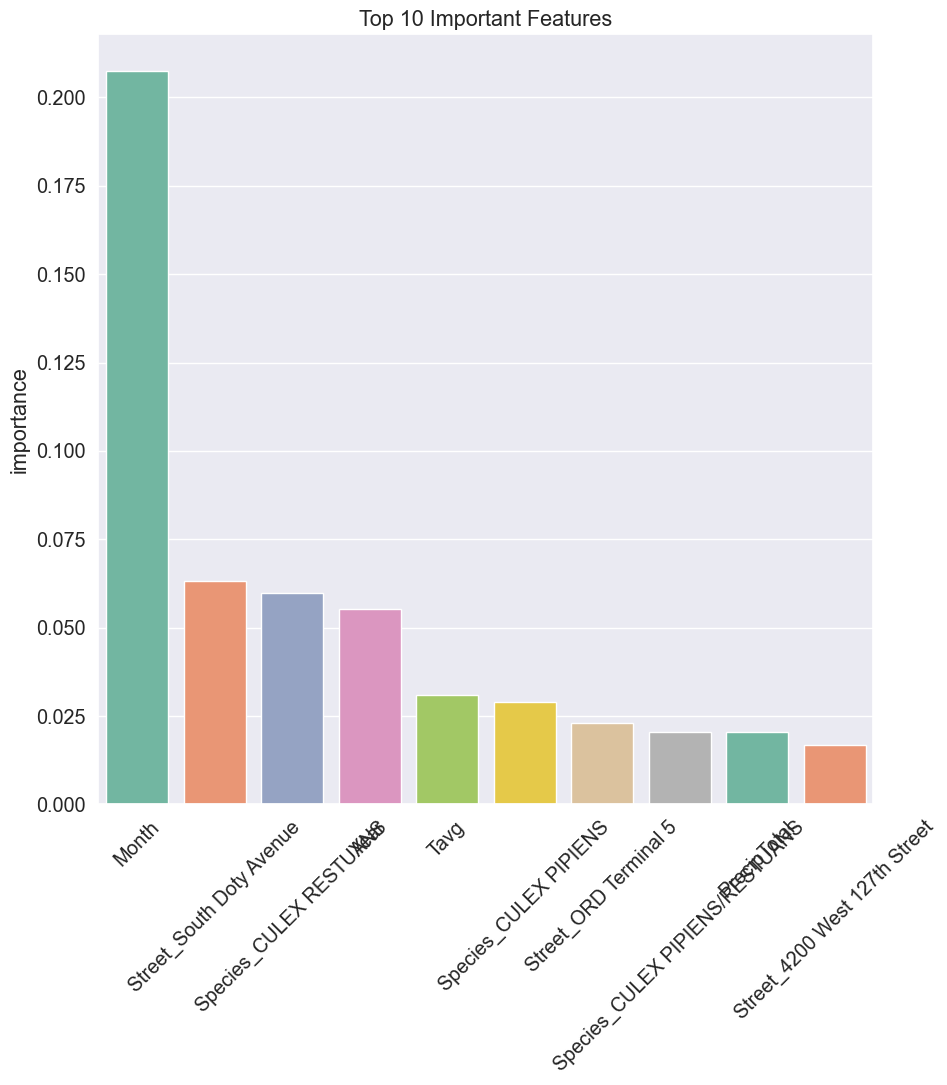

In [63]:
##Find important features predict WnvPresent = 1
feat_importance = pd.DataFrame(gs3.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])  
print(feat_importance.sort_values(by='importance', ascending=False).head(10))

#Visualize the important features top 10 in not barplot 

plt.figure(figsize=(10, 10))
sns.barplot(x=feat_importance.sort_values(by='importance', ascending=False).head(10).index, y=feat_importance.sort_values(by='importance', ascending=False).head(10)['importance'], palette='Set2')
plt.title('Top 10 Important Features')

plt.xticks(rotation=45)
plt.show()



In [64]:
#check the shape of test_model
print(test_model.shape)


#drop the columns that are not in X_train_sc, X_test_sc
test_model.drop(columns=['Species_UNSPECIFIED CULEX',
'Street_1100 South Loomis Street',
'Street_1200 West 120th Street',
'Street_1400 West 112th Street',
'Street_2600 East 136th Street',
'Street_2900 North Kenneth Avenue',
'Street_3400 North Long Avenue',
'Street_3700 North Kilbourn Avenue',
'Street_4000 North Kedvale Avenue',
'Street_4600 North Melvina Avenue',
'Street_5100 West 63rd Place',
'Street_6500 West Dakin Street',
'Street_South Baltimore Avenue',
'Street_South Oglesby Avenue',
'Trap_T234'], inplace=True)



#Check the shape of test_model after drop columns
print(test_model.shape)

(116293, 313)
(116293, 298)


In [65]:
test_model_sc = ss.transform(test_model)

#predict the test_model
pred = gs.predict_proba(test_model_sc)[:,1]

#submit the result
submission = pd.DataFrame({'Id': test_df['Id'], 'WnvPresent': pred})

#save the submission to csv
#submission.to_csv('submission_gb_best_logistic.csv', index=False)
